# Data Science Capstone Project


<a href="https://cognitiveclass.ai"><img src = "CambridgeMap.png" width = 400> </a>

<h1 align=center><font size = 5>Project-Cambridge, MA USA</font></h1>

The project consist of analysing the Cambridge city in Massachussets  
Because of the famous schools, Cambridge attracts many students from around the world.   
Many of the thousands of students of MIT, Harvard and Lesley University have not been in Cambridge before and therefore they are interested in learning about the city:  
-	Interesting places  
-	How safe if the city    
-	Differences in preferences between different neighborhoods  
-	Potential places to work because Cambridge is “the most innovative square mile on the planet.”  


The notebook has the following sections  
Setup imports  
		All the imports that might be necessary are imported here  
1-	Definition of constants  
•	All the constant variables used are defined here  
2-	Define Generic Functions  
•	Definition of generic functions used in the notebook except for the visualization functions that are defined in the visualization section 4  
•	Each function is documented  
3-	Get Data for Cambridge  
•	All the data retrieved is done in this section and the source is indicated in each case  
•	Get the latitude and longitude of Cambridge, MA  
i.	Using functions defined in section 2  
•	Populate all the areas defined with FourSquare APIs for venues in each area  
i.	Using functions defined in section 2  
•	Get nearby Venues
i.	Using functions defined in section 2  
•	Retrieve zip codes longitude and latitude  
i.	From the Cambridge open data described before  
•	Scrape from the Cambridge wikipedia the following  
i.	Income by zip code  
ii.	Main employers in Cambridge  
•	Load crime reports from Cambridge Open data  
i.	Create two data frames  
1.	Total crimes by neighborhood  
2.	Total crimes ty type of crime  
•	Load the Cambridge definition of the polygones  
•	Load average salary information by type of job  
•	Load the Cambridge geo data in geojson format  
i.	Find the centroid for each Neighborhood  
ii.	Add crime data to each neighborhood to be able to show in a map the neighborhood and to total number of crimes  
4-	Data Visualization    
•	Define Utility functions for visualization  
i.	All the functions used for visualization are defined here  
•	Each visualization is documented  



## Setup imports

In [147]:
import numpy as np # library to handle data in a vectorized manner
# we are using the inline backend
%matplotlib inline 
import sys,time
import traceback

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import os
import os.path

from pprint import pformat

from mpl_toolkits.basemap import Basemap

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#import geopandas as gpd
import shapefile
print('Libraries imported.')

Libraries imported.


## 1- Definition of Constants 

### URL to use with FourSquare APIs

In [148]:
urlvenues = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&limit={}'
#.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, LIMIT)


In [149]:
urlvenuesbycat = 'https://api.foursquare.com/v2/venues/search?categoryid={},&client_id={}&client_secret={}&ll={},{}&v={}&limit={}'
#.format(categoryid,CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, LIMIT)


In [150]:
urlvenuesExplore = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
#format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
 

#### Define the client id and secret

In [151]:
# @hidden_cell
CLIENT_ID = 'LVECV440CCZXCS3WJ2BASTYXZKARSZM4T3ZGNNICBTSCRXDZ' # your Foursquare ID
#            LVECV440CCZXCS3WJ2BASTYXZKARSZM4T3ZGNNICBTSCRXDZ

#                05STJPJII2PLYWND1Q3TWYIM0RGZ30Z0NNNXBLJ4H0URF5YP
CLIENT_SECRET = '05STJPJII2PLYWND1Q3TWYIM0RGZ30Z0NNNXBLJ4H0URF5YP' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 10
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

### Define the addresses for the areas of interest in a Python dictionary
### addressDic format
### "name"
### > "address"
### > "latitude"
### > "longitude"
### > "df"   # data frame  with the data for and area filtered

In [152]:
LIMIT = 10

addressCambridge = "Cambridge,MA USA"
#"Cambridge City":{"address":addressCambridge},

# definition of the Importan Areas as the neighborhood to analyze

addressesDic = {"Lesley University":{"address":"29 Everett St, Cambridge, MA 02138"},
             "Biogen":{"address":"225 Binney St, Cambridge, MA 02142"},
             "MIT":{"address": "77 Massachusetts Ave, Cambridge, MA 02139"},
             "Cambridge Innovation Center":{"address":"1 Broadway, Cambridge, MA 02142"},
             "Harvard Square":{"address":"1400 Massachusetts Ave, Cambridge, MA 02138"},
             "Central Square":{"address":"581 Massachusetts Ave, Cambridge, MA 02139"},
             "Kendal Square":{"address":"325 Main St, Cambridge, MA 02142"}
            }

  

In [153]:
categoriesSet = set()
CategoriesColors = {}

## 1- END Constants

## 2- Definition Generic Utility Functions
## >  Notice that the utilities for visualization are in part 4 Visualization

In [154]:
# get the type of a variable
def getVarType(var):
    vartype = type(var).__name__
    return vartype    

# function that extracts the category of the venue in a row of df
def getCategoryType(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the data
# keep only columns that include venue name, and anything that is associated with location
def filterDF(df):        
    colsSelected= ['name', 'categories'] + [col for col in df.columns if col.startswith('location.')] + ['id']
    dfFiltered = df.loc[:, colsSelected]
    # filter the category for each row
    dfFiltered['categories'] = dfFiltered.apply(getCategoryType, axis=1)

    # clean column names by keeping only last term
    dfFiltered.columns = [column.split('.')[-1] for column in dfFiltered.columns]
    
    # eliminate rows that do not have a category
    dfFiltered.dropna(subset=['categories'],inplace=True)

    return dfFiltered

# get the latitude and longitude of an address    
def getLatitudeLongitude(address):
    try:
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        LATITUDE = location.latitude
        LONGITUDE = location.longitude
        return LATITUDE,LONGITUDE
    except:
        print("Exception in getLatitudeLongitude",traceback.format_exc())
        raise Exception("error in getLatitudeLongitude")    


def getDFAreas():
    dfAreas = addressesDic.get("dfAreas")
    return dfAreas

def setupAreasDF():
    dfAreas = pd.DataFrame(columns=["name","areanum","address","latitude","longitude"])
    areanum = 0
    for name,nameDic in addressesDic.items():
        if name == "dfAreas":
            continue
        
        address = nameDic.get("address")
        latitude,longitude = getLatitudeLongitude(address)
        areanum = areanum + 1
        newrow = {"name":name,"areanum":areanum,"address":address,
                  "latitude":latitude,"longitude":longitude}
        dfAreas = dfAreas.append(newrow,ignore_index=True)
    #display("dfAreas",dfAreas)
    addressesDic["dfAreas"] = dfAreas   
    return dfAreas
       
def setupCategories(df):
    cats = df.categories.unique().tolist()
    for cat in cats:
        categoriesSet.add(cat)

# the key dfAreas is not a venue but the combination of all venues with lat and long        
def populateVenues():
    for name,nameDic in addressesDic.items():
        if name == "dfAreas":
            continue
        address = nameDic.get("address")
        print(name," : ",address)
        latitude,longitude = getLatitudeLongitude(address)
        nameDic["latitude"] = latitude
        nameDic["longitude"] = longitude
        url2run = urlvenues.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, LIMIT)            
        results = requests.get(url2run).json()
        venues = results['response']['venues']
        # tranform venues into a dataframe
        dataframe = json_normalize(venues)
        dataframe = filterDF(dataframe)
        nameDic["df"] = dataframe
        setupCategories(dataframe)
    setupAreasDF()
    print("\n")   
    return addressesDic

# show the map for a spacific area or for all

def getAreaList(area):
    areaList = []
    if area is not None:
        areaType = getVarType(area)
        if areaType == "list":
            areaList = area
        elif areaType == "str":
            areaList.append(area)
        else:
            return None

    return areaList

# show the venue data for one area or a list of areas
def showVenues(area=None):
    areaList = getAreaList(area)
    if areaList is None:
        print("INVALID parameter passed. No action")
        return

    for name,nameDic in addressesDic.items():
        if name not in areaList:
            continue
        df = nameDic.get("df")
        display(name,df.head(2))
        display("shape",df.shape)
        display("columns",df.columns)
        if "neighborhood" in df.columns:
            display("neighborhood unique",df.neighborhood.unique())
        else:
            display("NO neighborhood")
        display("unique counts",df.categories.value_counts())

def showDfAreasInfo(name,df):
    print("\n=======================dfAreas==========\n",name)
    dfcols = df.columns.tolist()
    display("dfAreas cols",dfcols)
    display(df)            
        
def showVenuesInfo():
    print("\nThe following is the information for each arena")
    for name,nameDic in addressesDic.items():
        if name == "dfAreas":
            showDfAreasInfo(name,nameDic)
            continue
        df = nameDic.get("df")
        print("\n=======================\narea name: ",name)
        address = nameDic.get("address")
        print("address: ",address)
        print("shape: ",df.shape)
        print("columns: ",df.columns)
        latitude = nameDic.get("latitude")
        print("latitude: ",latitude)
        longitude = nameDic.get("longitude")
        print("longitude: ",longitude)
        if "neighborhood" in df.columns:
            print("neighborhood unique",df.neighborhood.unique())
        else:
            print("NO neighborhood")
        # using display to show dataframe in proper format
        display(name,df.head(2))

def searchVenuesByCategory(addressesDic):
    # navigate row by row the default for name is Pandas
    #for row in dfcats.intertuples(index=False, name="Pandas"):  # not in this version
    #for row in dfcats.interrows(): # not in this version
    nrows = len(dfCategories.index)
    for i in range(nrows):
        id = dfCategories.at[i,"id"]
        name = dfCategories.at[i,"name"]
        print(i," id:",id," name:",name)
        searchVenues(addressesDic,categoryid=id)
    


##  Function to explore venues around the defined Neighborhoods

In [155]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Process the venues data 
> ### creating onehot and grouping by Neighborhood

In [156]:
def processVenues(df_venues):
    display(df_venues)
    display(type(df_venues))
    # one hot encoding
    ncol = len(df_venues.columns.tolist())
    noprefix =[]
    for i in range(1):
        noprefix.append("")
        
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="",prefix_sep="")

    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = df_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]

    display("df_onehot",df_onehot.head(),df_onehot.shape)

    df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
    display("df_grouped",df_grouped,df_grouped.shape)
    return df_grouped


### Convert a shape file to a geojson file

In [157]:
def convertShap2DF(sfile):
    sf = shapefile.Reader(sfile)
    display("shapeTypeName",sf.shapeTypeName)
    fields = [x[0] for x in sf.fields][1:]
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    display("df",df.head(2))
    return df


### Functions used as apply DataFrame functions

In [158]:
def separateCoords0(coordList):
    return coordList[0]
    
def separateCoords1(coordList):
    return coordList[1]
    
    

In [159]:
def centroid(vertexes):
    xlist = [vertex [0] for vertex in vertexes]
    ylist = [vertex [1] for vertex in vertexes]
    lenVertex = len(vertexes)
    x = sum(xlist) / lenVertex
    y = sum(ylist) / lenVertex
    return x, y

def findCentroid(featuresDic,pos):
    properties = featuresDic.get("properties") 
    name = properties.get("name")
    geometryCoordsList = featuresDic.get("geometry").get("coordinates") 
    geometryCoords = geometryCoordsList[0] 
    geometryCoords = geometryCoords[0] 
    #print("geo type:",type(geometryCoords))
    #print("lencoords:",len(geometryCoords))
    xy = centroid(geometryCoords)
    #print("xy:",xy," x:",xy[0]," y:",xy[1])
    return xy[pos]

def findCentroid0(featuresDic):
    return findCentroid(featuresDic,0)
def findCentroid1(featuresDic):
    return findCentroid(featuresDic,1)

def getName(featuresDic):
    return featuresDic.get("properties").get("name") 
    
    

## 2- END of Utilities

## 3- Get Data for Cambridge

### Get near by venues

In [160]:
dfAreas = setupAreasDF()
display(dfAreas)
nearbyInAreas = getNearbyVenues(dfAreas["name"],dfAreas["latitude"],dfAreas["longitude"])
area_grouped = processVenues(nearbyInAreas)

,name,areanum,address,latitude,longitude
0,Lesley University,1,"29 Everett St, Cambridge, MA 02138",42.380166,-71.117264
1,Biogen,2,"225 Binney St, Cambridge, MA 02142",42.366773,-71.085587
2,MIT,3,"77 Massachusetts Ave, Cambridge, MA 02139",42.359296,-71.093083
3,Cambridge Innovation Center,4,"1 Broadway, Cambridge, MA 02142",42.362925,-71.082970
4,Harvard Square,5,"1400 Massachusetts Ave, Cambridge, MA 02138",42.373740,-71.119710
5,Central Square,6,"581 Massachusetts Ave, Cambridge, MA 02139",42.365020,-71.102763
6,Kendal Square,7,"325 Main St, Cambridge, MA 02142",42.362415,-71.086742


Lesley University
Biogen
MIT
Cambridge Innovation Center
Harvard Square
Central Square
Kendal Square


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lesley University,42.380166,-71.117264,Harvard Museum of Natural History,42.378410,-71.115720,Science Museum
1,Lesley University,42.380166,-71.117264,Berkman Klein Center for Internet & Society,42.380153,-71.117954,College Technology Building
2,Lesley University,42.380166,-71.117264,Peabody Museum of Archaeology and Ethnology,42.378146,-71.114734,History Museum
3,Lesley University,42.380166,-71.117264,Cambridge Common,42.381999,-71.119739,Pub
4,Lesley University,42.380166,-71.117264,BerryLine,42.382008,-71.119804,Ice Cream Shop
5,Lesley University,42.380166,-71.117264,Giulia,42.382511,-71.119709,Italian Restaurant
6,Lesley University,42.380166,-71.117264,Temple Bar,42.382721,-71.119777,American Restaurant
7,Lesley University,42.380166,-71.117264,Marathon Sports,42.381881,-71.119821,Sporting Goods Shop
8,Lesley University,42.380166,-71.117264,Honeycomb Creamery,42.383188,-71.119800,Ice Cream Shop
9,Lesley University,42.380166,-71.117264,Stereo Jack's Records,42.382640,-71.119728,Record Shop


pandas.core.frame.DataFrame

'df_onehot'

,Neighborhood,American Restaurant,Arepa Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,Burrito Place,Café,Cocktail Bar,Coffee Shop,College Gym,College Technology Building,Comedy Club,Concert Hall,Dance Studio,Event Space,French Restaurant,Garden,Gastropub,Greek Restaurant,Gym,Gym / Fitness Center,History Museum,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jewish Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Park,Pizza Place,Plaza,Pub,Record Shop,Rock Club,Salad Place,Science Museum,Skating Rink,Sporting Goods Shop,Supermarket,Vegetarian / Vegan Restaurant,Yoga Studio
0,Lesley University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Lesley University,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lesley University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lesley University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Lesley University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(70, 46)

'df_grouped'

,Neighborhood,American Restaurant,Arepa Restaurant,Bakery,Bar,Bookstore,Breakfast Spot,Burrito Place,Café,Cocktail Bar,Coffee Shop,College Gym,College Technology Building,Comedy Club,Concert Hall,Dance Studio,Event Space,French Restaurant,Garden,Gastropub,Greek Restaurant,Gym,Gym / Fitness Center,History Museum,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jewish Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Park,Pizza Place,Plaza,Pub,Record Shop,Rock Club,Salad Place,Science Museum,Skating Rink,Sporting Goods Shop,Supermarket,Vegetarian / Vegan Restaurant,Yoga Studio
0,Biogen,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0
1,Cambridge Innovation Center,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0
2,Central Square,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1
3,Harvard Square,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0
4,Kendal Square,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
5,Lesley University,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.2,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0
6,MIT,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(7, 46)

#### Let's print each neighborhood along with the top 5 most common venues

In [161]:
num_top_venues = len(dfAreas)

for hood in area_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = area_grouped[area_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Biogen----
               venue  freq
0  Jewish Restaurant   0.1
1        Event Space   0.1
2     Breakfast Spot   0.1
3       Skating Rink   0.1
4               Café   0.1
5      Movie Theater   0.1
6                Gym   0.1


----Cambridge Innovation Center----
                           venue  freq
0            American Restaurant   0.1
1                    Event Space   0.1
2                         Bakery   0.1
3  Vegetarian / Vegan Restaurant   0.1
4       Mediterranean Restaurant   0.1
5                   Skating Rink   0.1
6                           Café   0.1


----Central Square----
                           venue  freq
0                   Cocktail Bar   0.2
1            American Restaurant   0.1
2  Vegetarian / Vegan Restaurant   0.1
3                    Supermarket   0.1
4              Martial Arts Dojo   0.1
5                   Dance Studio   0.1
6                    Comedy Club   0.1


----Harvard Square----
                venue  freq
0              Bakery   0.1
1

#### Let's put that into a *pandas* dataframe

First, a function to sort the venues in descending order.

In [162]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [163]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = area_grouped['Neighborhood']

for ind in np.arange(area_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(area_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Biogen,Greek Restaurant,Garden,Skating Rink,French Restaurant,Event Space,Breakfast Spot,Café,Jewish Restaurant,Gym,Movie Theater
1,Cambridge Innovation Center,American Restaurant,Vegetarian / Vegan Restaurant,Bakery,Skating Rink,Garden,French Restaurant,Event Space,Café,Gym,Mediterranean Restaurant
2,Central Square,Cocktail Bar,Yoga Studio,Martial Arts Dojo,Bookstore,Comedy Club,Dance Studio,Vegetarian / Vegan Restaurant,American Restaurant,Supermarket,Record Shop
3,Harvard Square,Café,Arepa Restaurant,Bakery,Salad Place,Rock Club,Plaza,Pizza Place,Gastropub,Indie Movie Theater,Mexican Restaurant
4,Kendal Square,Coffee Shop,American Restaurant,Hotel Bar,Garden,Event Space,Gym,Vegetarian / Vegan Restaurant,Bookstore,Bar,Burrito Place
5,Lesley University,Ice Cream Shop,History Museum,Record Shop,College Technology Building,Italian Restaurant,Pub,American Restaurant,Science Museum,Sporting Goods Shop,Rock Club
6,MIT,College Gym,Pizza Place,Park,Burrito Place,Concert Hall,Café,Gym / Fitness Center,Bakery,Breakfast Spot,Arepa Restaurant


In [164]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Biogen,Greek Restaurant,Garden,Skating Rink,French Restaurant,Event Space,Breakfast Spot,Café,Jewish Restaurant,Gym,Movie Theater
1,Cambridge Innovation Center,American Restaurant,Vegetarian / Vegan Restaurant,Bakery,Skating Rink,Garden,French Restaurant,Event Space,Café,Gym,Mediterranean Restaurant
2,Central Square,Cocktail Bar,Yoga Studio,Martial Arts Dojo,Bookstore,Comedy Club,Dance Studio,Vegetarian / Vegan Restaurant,American Restaurant,Supermarket,Record Shop
3,Harvard Square,Café,Arepa Restaurant,Bakery,Salad Place,Rock Club,Plaza,Pizza Place,Gastropub,Indie Movie Theater,Mexican Restaurant
4,Kendal Square,Coffee Shop,American Restaurant,Hotel Bar,Garden,Event Space,Gym,Vegetarian / Vegan Restaurant,Bookstore,Bar,Burrito Place
5,Lesley University,Ice Cream Shop,History Museum,Record Shop,College Technology Building,Italian Restaurant,Pub,American Restaurant,Science Museum,Sporting Goods Shop,Rock Club
6,MIT,College Gym,Pizza Place,Park,Burrito Place,Concert Hall,Café,Gym / Fitness Center,Bakery,Breakfast Spot,Arepa Restaurant


## Notice the the areas of interest are used as cluster areas so we do not need to create arbitatry clusters

In [165]:
display("dfAreas cols",dfAreas.columns)
display("neighborhoods_venues_sorted",neighborhoods_venues_sorted.columns)

'dfAreas cols'

Index(['name', 'areanum', 'address', 'latitude', 'longitude'], dtype='object')

'neighborhoods_venues_sorted'

Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

### get the latitude and longitude of Cambridge, MA

In [166]:

latCambridge,longCambridge = getLatitudeLongitude(addressCambridge)
print("Cambridge latitude and longitude:",latCambridge," : ",longCambridge)

Cambridge latitude and longitude: 42.3750997  :  -71.1056157


### Populate all the areas defined with FourSquare APIs for venues in each area

In [167]:
populateVenues()
print("\nCategories\n",categoriesSet)

Lesley University  :  29 Everett St, Cambridge, MA 02138
Biogen  :  225 Binney St, Cambridge, MA 02142
MIT  :  77 Massachusetts Ave, Cambridge, MA 02139
Cambridge Innovation Center  :  1 Broadway, Cambridge, MA 02142
Harvard Square  :  1400 Massachusetts Ave, Cambridge, MA 02138
Central Square  :  581 Massachusetts Ave, Cambridge, MA 02139
Kendal Square  :  325 Main St, Cambridge, MA 02142



Categories
 {'Bus Station', 'Supermarket', 'Gourmet Shop', 'College Science Building', 'General College & University', 'Big Box Store', 'Plaza', 'Police Station', 'Yoga Studio', 'Cafeteria', 'New American Restaurant', 'Gym', 'Office', 'College Academic Building', 'Japanese Restaurant', 'Farmers Market', 'Library', 'Food & Drink Shop', 'Grocery Store', 'College Classroom', 'Dog Run', 'College Administrative Building', 'College Residence Hall', 'Gastropub', 'Vegetarian / Vegan Restaurant', 'Coffee Shop', 'Building', 'Bank', 'Bookstore', 'Deli / Bodega', 'Hotel', 'Indian Restaurant', 'Arcade', 'Noodl

In [168]:
showVenuesInfo()


The following is the information for each arena

area name:  Lesley University
address:  29 Everett St, Cambridge, MA 02138
shape:  (10, 15)
columns:  Index(['name', 'categories', 'lat', 'lng', 'labeledLatLngs', 'distance',
       'postalCode', 'cc', 'city', 'state', 'country', 'formattedAddress',
       'address', 'crossStreet', 'id'],
      dtype='object')
latitude:  42.38016555
longitude:  -71.11726360102577
NO neighborhood


'Lesley University'

,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,crossStreet,id
0,Lesley University - Stebbins Hall,College Classroom,42.380295,-71.117269,"[{'label': 'display', 'lat': 42.38029478221258...",14,02138,US,Cambridge,MA,United States,"[Cambridge, MA 02138, United States]",NaN,NaN,4c8e0d81ad70a1439ff8850f
1,Alumni Hall,College Academic Building,42.380032,-71.117194,"[{'label': 'display', 'lat': 42.38003171738600...",15,NaN,US,Cambridge,MA,United States,"[Cambridge, MA, United States]",NaN,NaN,52fe68d5498e0e5436b7b978



area name:  Biogen
address:  225 Binney St, Cambridge, MA 02142
shape:  (9, 15)
columns:  Index(['name', 'categories', 'address', 'lat', 'lng', 'labeledLatLngs',
       'distance', 'postalCode', 'cc', 'city', 'state', 'country',
       'formattedAddress', 'crossStreet', 'id'],
      dtype='object')
latitude:  42.366773
longitude:  -71.085587
NO neighborhood


'Biogen'

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Cambridge Police Department,Police Station,125 6th St,42.367290,-71.085746,"[{'label': 'display', 'lat': 42.36729037430749...",59,02142,US,Cambridge,MA,United States,"[125 6th St, Cambridge, MA 02142, United States]",NaN,4b7c3908f964a52085852fe3
1,"Biogen, Bio-1",Office,225 Binney St,42.364447,-71.086753,"[{'label': 'display', 'lat': 42.36444665061278...",276,02142,US,Cambridge,MA,United States,"[225 Binney St, Cambridge, MA 02142, United St...",NaN,5240e21511d2b2c47a61cc6c



area name:  MIT
address:  77 Massachusetts Ave, Cambridge, MA 02139
shape:  (10, 16)
columns:  Index(['name', 'categories', 'address', 'lat', 'lng', 'labeledLatLngs',
       'distance', 'postalCode', 'cc', 'city', 'state', 'country',
       'formattedAddress', 'crossStreet', 'neighborhood', 'id'],
      dtype='object')
latitude:  42.3592962
longitude:  -71.09308333242714
neighborhood unique [nan 'MIT']


'MIT'

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,MIT Building 7 (Rogers Building),College Administrative Building,77 Massachusetts Ave,42.359408,-71.093483,"[{'label': 'display', 'lat': 42.35940793494591...",35,02139,US,Cambridge,MA,United States,"[77 Massachusetts Ave, Cambridge, MA 02139, Un...",NaN,NaN,4ab97b54f964a520917f20e3
1,Massachusetts Institute of Technology (MIT),University,77 Massachusetts Ave,42.358148,-71.095051,"[{'label': 'display', 'lat': 42.35814751631250...",206,02139,US,Cambridge,MA,United States,"[77 Massachusetts Ave (at Vassar St), Cambridg...",at Vassar St,MIT,4ac38c31f964a520bd9b20e3



area name:  Cambridge Innovation Center
address:  1 Broadway, Cambridge, MA 02142
shape:  (10, 15)
columns:  Index(['name', 'categories', 'lat', 'lng', 'labeledLatLngs', 'distance', 'cc',
       'city', 'state', 'country', 'formattedAddress', 'address',
       'crossStreet', 'postalCode', 'id'],
      dtype='object')
latitude:  42.362925
longitude:  -71.08297
NO neighborhood


'Cambridge Innovation Center'

,name,categories,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,address,crossStreet,postalCode,id
0,Kendall Square Dog Park,Dog Run,42.363248,-71.081875,"[{'label': 'display', 'lat': 42.363248, 'lng':...",96,US,Cambridge,MA,United States,"[Cambridge, MA, United States]",NaN,NaN,NaN,5159bbd6e4b0648154b6c6cd
1,Commonwealth,New American Restaurant,42.363306,-71.082668,"[{'label': 'display', 'lat': 42.36330630462683...",49,US,Cambridge,MA,United States,"[11 Broad Canal Way (3rd Street), Cambridge, M...",11 Broad Canal Way,3rd Street,02142,52792ebb498e254814bf817f



area name:  Harvard Square
address:  1400 Massachusetts Ave, Cambridge, MA 02138
shape:  (10, 15)
columns:  Index(['name', 'categories', 'address', 'crossStreet', 'lat', 'lng',
       'labeledLatLngs', 'distance', 'postalCode', 'cc', 'city', 'state',
       'country', 'formattedAddress', 'id'],
      dtype='object')
latitude:  42.37374025
longitude:  -71.11971035090022
NO neighborhood


'Harvard Square'

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Harvard Coop Society Bookstore,Bookstore,1400 Massachusetts Ave,at Brattle St.,42.373617,-71.119560,"[{'label': 'display', 'lat': 42.37361737582152...",18,02138,US,Cambridge,MA,United States,"[1400 Massachusetts Ave (at Brattle St.), Camb...",49f621a5f964a520086c1fe3
1,Newbury Comics,Record Shop,36 JFK St,at Mt Auburn St,42.372453,-71.119389,"[{'label': 'display', 'lat': 42.37245251492287...",145,02138,US,Cambridge,MA,United States,"[36 JFK St (at Mt Auburn St), Cambridge, MA 02...",4a590c14f964a52083b81fe3



area name:  Central Square
address:  581 Massachusetts Ave, Cambridge, MA 02139
shape:  (10, 15)
columns:  Index(['name', 'categories', 'address', 'crossStreet', 'lat', 'lng',
       'labeledLatLngs', 'distance', 'postalCode', 'cc', 'city', 'state',
       'country', 'formattedAddress', 'id'],
      dtype='object')
latitude:  42.36502
longitude:  -71.102763
NO neighborhood


'Central Square'

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Paris Baguette,Bakery,581 Massachusetts Ave,Essex St,42.364971,-71.102712,"[{'label': 'display', 'lat': 42.36497097715225...",6,02139,US,Cambridge,MA,United States,"[581 Massachusetts Ave (Essex St), Cambridge, ...",53584d76498e6d68a7330e48
1,Go! Go! Curry,Japanese Restaurant,581 Massachusetts Ave,NaN,42.365000,-71.102684,"[{'label': 'display', 'lat': 42.3649998032856,...",6,02139,US,Cambridge,MA,United States,"[581 Massachusetts Ave, Cambridge, MA 02139, U...",5357f9f6498e979d058af31e



area name:  Kendal Square
address:  325 Main St, Cambridge, MA 02142
shape:  (10, 16)
columns:  Index(['name', 'categories', 'address', 'crossStreet', 'lat', 'lng',
       'labeledLatLngs', 'distance', 'postalCode', 'cc', 'city', 'state',
       'country', 'formattedAddress', 'neighborhood', 'id'],
      dtype='object')
latitude:  42.36241486111111
longitude:  -71.08674166666665
neighborhood unique [nan 'Kendall Square']


'Kendal Square'

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,MBTA Kendall/MIT Station,Metro Station,Main St.,at Broadway,42.362407,-71.085661,"[{'label': 'display', 'lat': 42.36240744243955...",88,02142,US,Cambridge,MA,United States,"[Main St. (at Broadway), Cambridge, MA 02142, ...",NaN,4a78fc5af964a520c5e61fe3
1,Clover Food Lab KND,Vegetarian / Vegan Restaurant,5 Cambridge Ctr,at Dock St,42.362555,-71.087259,"[{'label': 'display', 'lat': 42.36255507491542...",45,02142,US,Cambridge,MA,United States,"[5 Cambridge Ctr (at Dock St), Cambridge, MA 0...",NaN,52a9e5c611d272d34c168c68



=======================dfAreas==========
 dfAreas


'dfAreas cols'

['name', 'areanum', 'address', 'latitude', 'longitude']

,name,areanum,address,latitude,longitude
0,Lesley University,1,"29 Everett St, Cambridge, MA 02138",42.380166,-71.117264
1,Biogen,2,"225 Binney St, Cambridge, MA 02142",42.366773,-71.085587
2,MIT,3,"77 Massachusetts Ave, Cambridge, MA 02139",42.359296,-71.093083
3,Cambridge Innovation Center,4,"1 Broadway, Cambridge, MA 02142",42.362925,-71.082970
4,Harvard Square,5,"1400 Massachusetts Ave, Cambridge, MA 02138",42.373740,-71.119710
5,Central Square,6,"581 Massachusetts Ave, Cambridge, MA 02139",42.365020,-71.102763
6,Kendal Square,7,"325 Main St, Cambridge, MA 02142",42.362415,-71.086742


### get latitude and longitude by zip code in Cambridge
## > data from https://public.opendatasoft.com

In [169]:
ziplatlongfile = "us-zip-code-latitude-and-longitude.csv"
zipLatLongCambDF= pd.read_csv(ziplatlongfile,sep=";")
#display(zipLatLongCambDF.head())
zipLatLongCambDF = zipLatLongCambDF[zipLatLongCambDF["City"] == "Cambridge"]
#display(zipLatLongCambDF)
col2sel = ["Zip","Latitude","Longitude"]
zipLatLongCambDF = zipLatLongCambDF[col2sel]
display(zipLatLongCambDF)


,Zip,Latitude,Longitude
11,2139,42.364347,-71.104310
62,2142,42.362297,-71.084120
132,2138,42.379146,-71.128030
181,2141,42.370519,-71.084430
299,2140,42.393327,-71.128370
348,2239,42.446396,-71.459405
577,2238,42.446396,-71.459405


### Get Cambridge info from wikipedia 
## 1.  Income by zipcode
## 2. Main employeers


In [170]:
urlwiki = "https://en.wikipedia.org/wiki/Cambridge,_Massachusetts"

In [171]:
all = pd.read_html(urlwiki,header=0) 

### The reading from wikipedia returns a list of dataframes.
### Looping thru the list we can find what positions in the list have the data we need

In [172]:
nall = len(all)
for n in range(nall):
    df = pd.read_html(urlwiki,header=0)[n]
    position = "position "+str(n)
    indList = df.columns.tolist()
    if "Unnamed" in indList[0]: # ignore those that are not dataframes
        continue
    display(position,df.head(1))



'position 0'

,"Cambridge, Massachusetts","Cambridge, Massachusetts.1"
0,City,City


'position 4'

,Historical population,Historical population.1,Historical population.2
0,Year,Pop.,±%


'position 5'

,Racial composition,2010[50],1990[51],1970[51],1950[51]
0,White,66.6%,75.3%,91.1%,95.3%


'position 7'

,Rank,ZIP Code (ZCTA),Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,02142,"$67,525","$100,114","$150,774",2838,1385


'position 9'

,#,Employer,# of employees
0,1,Harvard University,11997


'position 12'

,"Voter registration and party enrollment as of February 12, 2020[84]","Voter registration and party enrollment as of February 12, 2020[84].1","Voter registration and party enrollment as of February 12, 2020[84].2","Voter registration and party enrollment as of February 12, 2020[84].3","Voter registration and party enrollment as of February 12, 2020[84].4","Voter registration and party enrollment as of February 12, 2020[84].5"
0,Party,Party,Number of voters,Percentage,NaN,NaN


'position 13'

,Year,Democratic,Republican
0,2016,"87.9% 46,563","6.3% 3,323"


'position 14'

,District,Councillor,In office since
0,At-large,Dennis J. Carlone,Jan. 2014–present


'position 16'

,Callsign,Frequency,City/town,Licensee,Format
0,WHRB,95.3 FM,Cambridge (Harvard),"Harvard Radio Broadcasting Co., Inc.",Musical variety


'position 20'

,"vteCambridge, Massachusetts","vteCambridge, Massachusetts.1"
0,History,Timeline


'position 21'

,Links to related articles,Links to related articles.1,Unnamed: 2
0,"vteRegion of Greater BostonCounties Belknap, N...","vteRegion of Greater BostonCounties Belknap, N...",NaN


'position 22'

,vteRegion of Greater Boston,vteRegion of Greater Boston.1
0,Counties,"Belknap, NH Bristol, MA Bristol, RI Essex, MA ..."


'position 23'

,"vteMunicipalities and communities of Middlesex County, Massachusetts, United States","vteMunicipalities and communities of Middlesex County, Massachusetts, United States.1","vteMunicipalities and communities of Middlesex County, Massachusetts, United States.2"
0,County seats: Cambridge and Lowell,County seats: Cambridge and Lowell,County seats: Cambridge and Lowell


'position 24'

,vte Commonwealth of Massachusetts,vte Commonwealth of Massachusetts.1,vte Commonwealth of Massachusetts.2
0,Boston (capital),Boston (capital),Boston (capital)


'position 25'

,vteNew England,vteNew England.1
0,Topics,Autumn Climate Cuisine Culture Demographics Ec...


'position 26'

,Passenger rail,"MBTA (MA, RI) Northeast Corridor (CT, MA, RI) Acela Express (CT, MA, RI) Downeaster (ME, NH, MA) Vermonter (CT, MA, NH, VT) Shore Line East (CT) Metro-North (CT) Hartford Line (CT, MA) High-speed Northern New England (proposed)"
0,Major Interstates,"I-84 (CT, MA) I-89 (NH, VT) I-90 (Mass Pike) (..."


'position 27'

,"vteMayors of cities with populations exceeding 100,000 in Massachusetts","vteMayors of cities with populations exceeding 100,000 in Massachusetts.1","vteMayors of cities with populations exceeding 100,000 in Massachusetts.2"
0,Marty Walsh(Boston) Joseph M. Petty(Worcester)...,Marty Walsh(Boston) Joseph M. Petty(Worcester)...,NaN


'position 28'

,vteNortheast megalopolis,vteNortheast megalopolis.1
0,"Major metropolitan areas (over 1,000,000)",New York city Philadelphia city Washington cit...


'position 29'

,vteNortheastern United States,vteNortheastern United States.1
0,Topics,Culture Geography Government History


'position 30'

,Authority control,BNF: cb11951255z (data) GND: 4009352-9 MusicBrainz: ff1b74fd-054b-4136-b948-bb88fe55d93f MusicBrainz: 12220eef-cdfb-4291-ac43-41c4f1d1d23a NARA: 10045468 NKC: ge134104 SELIBR: 142024 VIAF: 157775450 WorldCat Identities (via VIAF): 157775450


### Looking at the output we find that the following positions have the data we need
### Position 7 - Income by zip code
### Position 9 - Main Employeers in Cambridge

In [173]:
dfIncome = pd.read_html(urlwiki,header=0)[7]
dfIncome = dfIncome.dropna()
dfIncome.head(10)

,Rank,ZIP Code (ZCTA),Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,02142,"$67,525","$100,114","$150,774",2838,1385
1,2.0,02138,"$52,592","$75,446","$120,564",35554,13868
2,3.0,02140,"$50,856","$75,446","$120,564",18164,8460
5,4.0,02139,"$42,235","$71,745","$93,220",36015,14474
6,5.0,02141,"$39,241","$64,326","$76,276",13126,6182


In [174]:
dfEmployeers = pd.read_html(urlwiki,header=0)[9]
dfEmployeers.head(10)

,#,Employer,# of employees
0,1,Harvard University,11997
1,2,Massachusetts Institute of Technology,8763
2,3,City of Cambridge,2950
3,4,Biogen,2700
4,5,Novartis,2457
5,6,Mount Auburn Hospital,2115
6,7,Cambridge Health Alliance,1713
7,8,Cambridge Innovation Center,1678
8,9,Genzyme,1600
9,10,Akamai Technologies,1544


### Load  crimes reports by Neighborhood 
### from Cambridge Open data
https://data.cambridgema.gov/widgets/xuad-73uj

In [175]:
dfCrimes = pd.read_csv("Crime_Reports.csv")
#display("col dfcrimes",dfCrimes.Neighborhood.unique())
dfCrimes.loc[dfCrimes['Neighborhood'] == 'Area 4', 'Neighborhood'] = 'The Port'
dfCrimes.loc[dfCrimes['Neighborhood'] == 'Peabody', 'Neighborhood'] = 'Neighborhood Nine'
dfCrimes.loc[dfCrimes['Neighborhood'] == 'Inman/Harrington', 'Neighborhood'] = 'Wellington-Harrington'

#display("col dfcrimes after",dfCrimes.Neighborhood.unique())
#dfCrimes = dfCrimes[["Crime Date Time","Crime","Neighborhood"]]
#display("columns",dfCrimes.columns)
#display("total head",dfCrimes.head(3))
dfCrimes.sort_values(by=["Neighborhood"],inplace=True,ascending=False)
#display("sorted",dfCrimes.head())
#dfCrimesGroup = dfCrimes.groupby("Neighborhood").count()
#display(dfCrimesGroup.head())
dfCrimes = dfCrimes[["Crime","Neighborhood"]]
#display("shape",dfCrimes.shape)
#display("crimes",dfCrimes.head())
#display("crimes unique",dfCrimes.Crime.unique())

dfCrimesGroup = dfCrimes.groupby("Neighborhood",as_index=False)
#display("group type:",type(dfCrimesGroup))
#display("groupby",dfCrimesGroup.head())
dfCrimesGroupCount = dfCrimesGroup.count()
#display("dfCrimesGroupCount",dfCrimesGroupCount)
dfCrimesGroupCount.sort_values(by=["Crime"],inplace=True,ascending=False)
dfCrimesGroupByNeighborhood = dfCrimesGroupCount.reset_index(drop=True)
dfCrimesGroupByNeighborhood = dfCrimesGroupByNeighborhood.rename(columns = {'Crime':'TotalCrimes'})

display("dfCrimesGroupByNeighborhood sorted",dfCrimesGroupByNeighborhood)

dfCrimesGroupCrime = dfCrimes.groupby("Crime",as_index=False)
#display("groupbydfCrimesGroupCrime",dfCrimesGroupCrime.head(5))
#dfCrimesGroupCrime.sort_values(by=["Crime"],inplace=True,ascending=False)
dfCrimesGroupCrimeCount = dfCrimesGroupCrime.count()
#display("dfCrimesGroupCrimeCount",dfCrimesGroupCrimeCount)
dfCrimesGroupCrimeCount = dfCrimesGroupCrimeCount.rename(columns = {'Neighborhood':'CrimeCount'})
dfCrimesGroupCrimeCount["CrimeCount"] = dfCrimesGroupCrimeCount["CrimeCount"].astype(int)
#print("\nRENAMED\n")
#print("types\n",dfCrimesGroupCrimeCount.dtypes)
#display("dfCrimesGroupCrimeCount rename",dfCrimesGroupCrimeCount)
dfCrimesGroupCrimeCountSel = \
dfCrimesGroupCrimeCount.loc[dfCrimesGroupCrimeCount["CrimeCount"] > 1900]

#display("dfCrimesGroupCrimeCountSel",dfCrimesGroupCrimeCountSel)
dfCrimesGroupCrimeCountSel.sort_values(by=["CrimeCount"],inplace=True,ascending=False)

dfCrimesGroupByCrime = dfCrimesGroupCrimeCountSel.reset_index(drop=True)
display("dfCrimesGroupByCrime sorted",dfCrimesGroupByCrime)


'dfCrimesGroupByNeighborhood sorted'

,Neighborhood,TotalCrimes
0,Cambridgeport,9906
1,East Cambridge,9415
2,West Cambridge,7218
3,Mid-Cambridge,6882
4,The Port,6832
5,Riverside,6664
6,North Cambridge,6599
7,Wellington-Harrington,4345
8,Neighborhood Nine,4254
9,Agassiz,1836


C:\Anaconda2020\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'dfCrimesGroupByCrime sorted'

,Crime,CrimeCount
0,Hit and Run,6690
1,Larceny from MV,5717
2,Mal. Dest. Property,4665
3,Shoplifting,3929
4,Larceny of Bicycle,3875
5,Larceny from Building,3697
6,Warrant Arrest,3559
7,Forgery,3556
8,Housebreak,3159
9,Simple Assault,2873


### Load  the neighborhood polygons
### from Cambridge Open data
https://data.cambridgema.gov/Planning/Cambridge-Neighborhood-Polygons/4ys2-ebga

In [176]:
dfPolygons = pd.read_csv('NhoodPolygons.csv')
display("shape",dfPolygons.shape)
dfPolygons.head(15)

'shape'

(13, 7)

,N_HOOD,NAME,GlobalID,the_geom,Webpage,Shape_area,Shape_len
0,4,The Port,{ED5E3360-A5DC-4A94-B1A2-56667062B754},MULTIPOLYGON (((-71.09852810085053 42.37184380...,http://www.cambridgema.gov/CDD/planud/neighpla...,8.346206e+06,11801.706662
1,9,Neighborhood Nine,{5C8D020B-4883-4D21-AF50-2CC939451E04},MULTIPOLYGON (((-71.13044357856809 42.39027976...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.776818e+07,20099.989638
2,2,Area 2/MIT,{10FB33A8-55D2-4C22-B558-7F553139CE4E},MULTIPOLYGON (((-71.07808844762503 42.35799896...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.774211e+07,22041.386902
3,5,Cambridgeport,{2B966564-1135-4BE9-AE29-D94BBCCA61CD},MULTIPOLYGON (((-71.11678700433382 42.36121915...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.580966e+07,16038.114882
4,7,Riverside,{299A713A-BD58-46F8-9CF0-9AAF155E0294},MULTIPOLYGON (((-71.12318467152328 42.36894489...,http://www.cambridgema.gov/CDD/planud/neighpla...,9.575448e+06,15019.678412
5,6,Mid-Cambridge,{01C9B143-6C4E-474A-8AFE-3E0C59D25989},MULTIPOLYGON (((-71.10726863582971 42.37809799...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.298083e+07,15198.295124
6,3,Wellington-Harrington,{62554B14-9B06-421D-BD6F-FBC78BD8D8A4},MULTIPOLYGON (((-71.08749509775691 42.37328477...,http://www.cambridgema.gov/CDD/planud/neighpla...,6.609875e+06,11769.746495
7,1,East Cambridge,{7FB4DD2D-34A9-48FE-BE3B-97270FA86326},MULTIPOLYGON (((-71.07838791866659 42.37386457...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.979585e+07,20067.077021
8,8,Agassiz,{8E7ED0D1-E661-40EB-BC23-374A3E39567B},MULTIPOLYGON (((-71.10842097795496 42.37911237...,http://www.cambridgema.gov/CDD/planud/neighpla...,8.203376e+06,13107.332352
9,12,Cambridge Highlands,{C0F9BF06-53F0-47EE-A291-82B172955DBF},MULTIPOLYGON (((-71.15650382338076 42.39575139...,http://www.cambridgema.gov/CDD/planud/neighpla...,1.477103e+07,17549.804363


### Get salaries information by type of job
from https://www.payscale.com/research/US/Location=Cambridge-MA/Salary

In [177]:
dfCamAvgSal = pd.read_csv("CambridgeJobAverage.csv")
dfCamAvgSal.sort_values(by=["Average"],inplace=True,ascending=False)
display(dfCamAvgSal.dtypes)
dfCamAvgSal.head()

Job        object
Average     int64
dtype: object

,Job,Average
6,Senior Software Engineer,126762
2,Senior Research Scientist-Biotechnology,114491
1,Research Scientist,99256
3,Research Scientist-Biotechnology,98537
0,Software Engineer,97070


### Cambridge popular employers

In [180]:
dfPopEmployeers = pd.read_csv("Popular Employers in Cambridge,.csv")
display(dfPopEmployeers.dtypes)
dfPopEmployeers.head()

employer      object
salaryfrom     int64
salaryto       int64
dtype: object

,employer,salaryfrom,salaryto
0,Harvard University,48000,115000
1,Massachusetts Institute of Technology (MIT),48000,117000
2,Takeda Pharmaceuticals,67000,141000
3,Biogen Inc,67000,169000
4,Broad Institute,47000,113000


In [181]:
display(dfEmployeers.head())
dfPopEmployeers.insert(2,"average",(dfPopEmployeers["salaryfrom"] + dfPopEmployeers["salaryto"])/2)
dfPopEmployeers["average"] = dfPopEmployeers["average"].astype(int)
display(dfPopEmployeers.dtypes)
dfPopEmployeers.head()


,#,Employer,# of employees
0,1,Harvard University,11997
1,2,Massachusetts Institute of Technology,8763
2,3,City of Cambridge,2950
3,4,Biogen,2700
4,5,Novartis,2457


employer      object
salaryfrom     int64
average        int32
salaryto       int64
dtype: object

,employer,salaryfrom,average,salaryto
0,Harvard University,48000,81500,115000
1,Massachusetts Institute of Technology (MIT),48000,82500,117000
2,Takeda Pharmaceuticals,67000,104000,141000
3,Biogen Inc,67000,118000,169000
4,Broad Institute,47000,80000,113000


### top 25 employers
### from Cambridge Open data
https://data.cambridgema.gov/Economic-Development/Top-25-Employers-1995-2019/77wt-9zvn/data

In [182]:
dfTop25Employeers = pd.read_csv("Top_25_Employers__1995_-_2019.csv")
display(dfTop25Employeers.dtypes)
dfTop25Employeers.head()

Year           int64
Company       object
Industry      object
Employment     int64
Rank           int64
dtype: object

,Year,Company,Industry,Employment,Rank
0,1995,HARVARD UNIVERSITY,HIGHER EDUCATION,10300,1
1,1995,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,HIGHER EDUCATION,8188,2
2,1995,CITY OF CAMBRIDGE,GOVERNMENT,5305,3
3,1995,MT. AUBURN HOSPITAL,HEALTH CARE,2007,4
4,1995,POLAROID,MANUFACTURING,1829,5


### get neighborhood polygons geo data
## from Cambridge open data
https://data.cambridgema.gov/Planning/Cambridge-Neighborhood-Polygons/4ys2-ebga


In [183]:
neighborhoodDF = pd.read_json("Cambridge Neighborhood Polygons.geojson")
display("neigh",neighborhoodDF.columns)
display("neigh",neighborhoodDF.shape)
display("neigh",neighborhoodDF)

'neigh'

Index(['type', 'features'], dtype='object')

'neigh'

(13, 2)

'neigh'

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
5,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
6,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
7,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
8,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."
9,FeatureCollection,"{'type': 'Feature', 'properties': {'global_id'..."


## Find the centroid of each neighborhood (latitude and longitude)

In [184]:
neighborhoodDF["Neighborhood"] = neighborhoodDF["features"].apply(getName)
neighborhoodDF["centroidLong"] = neighborhoodDF["features"].apply(findCentroid0)
neighborhoodDF["centroidLat"] = neighborhoodDF["features"].apply(findCentroid1)
neighborhoodDF = neighborhoodDF.drop("features",axis=1)
neighborhoodDF = neighborhoodDF.drop("type",axis=1)
neighborhoodDF.loc[neighborhoodDF['Neighborhood'] == 'Area 2/MIT', 'Neighborhood'] = 'MIT'
neighborhoodDF.loc[neighborhoodDF['Neighborhood'] == 'Cambridge Highlands', 'Neighborhood'] = 'Highlands'

nunique = dfCrimesGroupByNeighborhood.Neighborhood.unique().tolist()
print("nunique type:",type(nunique))
nunique.sort()
print("nunique type:",type(nunique))
display("dfCrimesGroupByNeighborhood unique",nunique)
ndfunique = neighborhoodDF.Neighborhood.unique().tolist()
ndfunique.sort()
display("neighborhoodDF unique",ndfunique)
neighborhoodDF

nunique type: <class 'list'>
nunique type: <class 'list'>


'dfCrimesGroupByNeighborhood unique'

['Agassiz',
 'Cambridgeport',
 'East Cambridge',
 'Highlands',
 'MIT',
 'Mid-Cambridge',
 'Neighborhood Nine',
 'North Cambridge',
 'Riverside',
 'Strawberry Hill',
 'The Port',
 'Wellington-Harrington',
 'West Cambridge']

'neighborhoodDF unique'

['Agassiz',
 'Cambridgeport',
 'East Cambridge',
 'Highlands',
 'MIT',
 'Mid-Cambridge',
 'Neighborhood Nine',
 'North Cambridge',
 'Riverside',
 'Strawberry Hill',
 'The Port',
 'Wellington-Harrington',
 'West Cambridge']

,Neighborhood,centroidLong,centroidLat
0,The Port,-71.094034,42.364797
1,Neighborhood Nine,-71.132329,42.386972
2,MIT,-71.092221,42.359711
3,Cambridgeport,-71.106890,42.359727
4,Riverside,-71.113814,42.367556
5,Mid-Cambridge,-71.109056,42.373436
6,Wellington-Harrington,-71.092744,42.371820
7,East Cambridge,-71.078482,42.373160
8,Agassiz,-71.113650,42.381624
9,Highlands,-71.145350,42.391703


### Add crimes to neighborhood data

In [185]:
neighborhoodDFCrimes = pd.merge(neighborhoodDF,dfCrimesGroupByNeighborhood ,how="left",on="Neighborhood")
neighborhoodDFCrimes.sort_values(by=["TotalCrimes"],inplace=True,ascending=False)
neighborhoodDFCrimes

,Neighborhood,centroidLong,centroidLat,TotalCrimes
3,Cambridgeport,-71.106890,42.359727,9906
7,East Cambridge,-71.078482,42.373160,9415
11,West Cambridge,-71.138684,42.374174,7218
5,Mid-Cambridge,-71.109056,42.373436,6882
0,The Port,-71.094034,42.364797,6832
4,Riverside,-71.113814,42.367556,6664
12,North Cambridge,-71.133560,42.394099,6599
6,Wellington-Harrington,-71.092744,42.371820,4345
1,Neighborhood Nine,-71.132329,42.386972,4254
8,Agassiz,-71.113650,42.381624,1836


### END Get Data

# 4- Visualization

## 4-1 Define Utility Functions for Visualization

### Utilities to Display the map of the venue

In [186]:
def displayMap(latitude,longitude,popname,df):   
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=17) # generate map centred around the Conrad Hotel

    # add a red circle marker to represent the Conrad Hotel
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        color='red',
        popup=popname,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)

    # add the blue circle markers
    for lat, lng,label in zip(df.lat, df.lng,df.categories):
        label = '{}'.format(label)
        label = folium.Popup(label, parse_html=True)
        color2use = "blue"
        catcolor = CategoriesColors.get(label)
        if catcolor is not None:
            color2use = catcolor
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

    # display map
    display(venues_map)

# display the map for one area or a list of areas
def showMapWithVenues(area=None):
    areaList = getAreaList(area)
    if areaList is None:
        print("INVALID parameter passed. No action")
        return
    
    for name,nameDic in addressesDic.items():
        if name not in areaList:
            continue
            
        latitude = nameDic.get("latitude")
        longitude = nameDic.get("longitude")
        df = nameDic.get("df")
        print("\nMap for area: ",name,"\n")
        displayMap(latitude,longitude,name,df)
        print("\n")
    

In [187]:
def getColors(df):
    # set color scheme for the clusters
    x = np.arange(len(df))
    ys = [i + x + (i*x)**2 for i in range(len(df))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    return rainbow

#
#  params:
#       df - data frame to plot
#      xlabel - lable for the x axis
#      ylabel - label for the y axis
#      title  - plot title
#      col4xticks - column in df with the values for the xtick labels
#
def plotBarDF(df,xlabel,ylabel,title,col4xticks,color="blue",type="bar"):

    fig, ax = plt.subplots()
    df.plot(kind=type,ax=ax, xticks=df.index, rot=45,color=color)
    
    col4xtickVals = df[col4xticks]
    xticksval = []
    for i in range(len(col4xtickVals)):
        xticksval.append(col4xtickVals[i])
    ax.set_xticklabels(xticksval,ha="right")
    
    plt.xlabel(xlabel) # add to x-label to the plot
    plt.ylabel(ylabel) # add y-label to the plot
    plt.title(title) # add title to the plot
    plt.savefig("neighcrimes")

    plt.show()
    
    

In [188]:
def addMarkers(curmap,df,latcol,longcol,labelcol):
    for i in range(0,len(df)):
            longitude = df.iloc[i][longcol]
            latitude = df.iloc[i][latcol]
            label = df.iloc[i][labelcol]
            #print("long:",longitude," lat:",latitude," label:",label)
            folium.Marker(location=[longitude,latitude], popup=label).add_to(curmap)

    # add labels indicating neighborhood name
    style_function = "font-size: 15px; font-weight: bold"
    #curmap.add_child(
    #    folium.features.GeoJsonTooltip([name], style=style_function, labels=False))

    
# shos the Cambridge Boundaries in a map
def showBoundaries(df,markersDF=None,latcol=None,longcol=None,labelcol=None):
    # 
    cambridge_geo = r'Cambridge Neighborhood Polygons.geojson' # geojson file
    #cambridge_geo = r'BOUNDARY_CDDNeighborhoods.geojson' # geojson file
    #display("cam_geo",type(cambridge_geo))
    # Create map for cambridge
    cambridge_map = folium.Map(location=[latCambridge, longCambridge], zoom_start=13, tiles='OpenStreetMap')
    # generate choropleth map 
    cambridge_map.choropleth(
        geo_data=cambridge_geo,
        data=df,
        columns=['Neighborhood',"TotalCrimes"],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',  # Color MUST be a colorbrewer color
        fill_opacity=0.3, 
        line_opacity=0.6,
        legend_name='Cambridge Neighborhoods Boundaries')

    if markersDF is not None:
        addMarkers(cambridge_map,markersDF,latcol,longcol,labelcol)
        
    cambridge_map.add_tile_layer()
    # create a layer control
    folium.LayerControl().add_to(cambridge_map)
    # display map
    display(cambridge_map)

In [189]:
    
def showAreasOfInterest(df):
    # create map of Cambridge using latitude and longitude values
    map_cambridge= folium.Map(location=[latCambridge, longCambridge], zoom_start=12)

    cambridge_geo = r'Cambridge Neighborhood Polygons.geojson' # geojson file
    #cambridge_map = folium.Map(location=[latCambridge, longCambridge], zoom_start=13, tiles='OpenStreetMap')
    # generate choropleth map 
    map_cambridge.choropleth(
        geo_data=cambridge_geo,
        data=df,
        columns=['name',"areanum"],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',  # Color MUST be a colorbrewer color
        fill_opacity=0.3, 
        line_opacity=0.6,
        legend_name='Cambridge Areas of Interest')

    colors = getColors(df)
    
    # add markers to map
    for lat, lng, name, address,areanum in zip(df['latitude'], df['longitude'], 
                                               df['name'],df["address"],df["areanum"]):
        label = '{} {}'.format(name,address)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color="green",
            #color=colors[areanum-1],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cambridge)  

    display(map_cambridge)

In [190]:

    
def showNeighborhoodCrimesBound(df):
    # create map of Cambridge using latitude and longitude values
    map_cambridge= folium.Map(location=[latCambridge, longCambridge], zoom_start=12)

    cambridge_geo = r'Cambridge Neighborhood Polygons.geojson' # geojson file
    #cambridge_map = folium.Map(location=[latCambridge, longCambridge], zoom_start=13, tiles='OpenStreetMap')
    # generate choropleth map 
    map_cambridge.choropleth(
        geo_data=cambridge_geo,
        data=df,
        columns=['Neighborhood',"TotalCrimes"],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',  # Color MUST be a colorbrewer color
        fill_opacity=0.3, 
        line_opacity=0.6,
        name="CAMBRIDGE BOUNDARIES",
        legend_name='Cambridge Neighborhood Crimes')

    # add markers to map
    for lat, lng, name, crimes in zip(df['centroidLat'], df['centroidLong'], 
                                               df['Neighborhood'],df["TotalCrimes"]):
        crimesrad = crimes/1000 + 3
        label = '{} {} crimes'.format(name,crimes)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=crimesrad,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cambridge)  

    display(map_cambridge)

def showNeighborhoodCrimes(df):
    # create map of Cambridge using latitude and longitude values
    map_cambridge= folium.Map(location=[latCambridge, longCambridge], zoom_start=13)

    # add markers to map
    for lat, lng, name, crimes in zip(df['centroidLat'], df['centroidLong'], 
                                               df['Neighborhood'],df["TotalCrimes"]):
        crimesrad = crimes/1000 + 3
        label = '{} {} crimes'.format(name,crimes)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=crimesrad,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cambridge)  

    display(map_cambridge)
    
def showNeighborhoods(neighborhoodDF):
    # create map of Cambridge using latitude and longitude values
    map_cambridge= folium.Map(location=[latCambridge, longCambridge], zoom_start=12)

    # add markers to map
    for lat, lng, name in zip(neighborhoodDF['centroidLat'], neighborhoodDF['centroidLong'], 
                                               neighborhoodDF['Neighborhood']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_cambridge)  

    display(map_cambridge)

## 4-1 END Utilities for Visualization

### Show the Cambridge city boundaries

In [191]:
showBoundaries(neighborhoodDFCrimes)

In [192]:
dfAreas = getDFAreas()
display(dfAreas.head(10))
showAreasOfInterest(dfAreas)

,name,areanum,address,latitude,longitude
0,Lesley University,1,"29 Everett St, Cambridge, MA 02138",42.380166,-71.117264
1,Biogen,2,"225 Binney St, Cambridge, MA 02142",42.366773,-71.085587
2,MIT,3,"77 Massachusetts Ave, Cambridge, MA 02139",42.359296,-71.093083
3,Cambridge Innovation Center,4,"1 Broadway, Cambridge, MA 02142",42.362925,-71.082970
4,Harvard Square,5,"1400 Massachusetts Ave, Cambridge, MA 02138",42.373740,-71.119710
5,Central Square,6,"581 Massachusetts Ave, Cambridge, MA 02139",42.365020,-71.102763
6,Kendal Square,7,"325 Main St, Cambridge, MA 02142",42.362415,-71.086742


In [193]:
showNeighborhoods(neighborhoodDF)

In [194]:
showNeighborhoodCrimesBound(neighborhoodDFCrimes)

## Analyze venues

In [195]:
showMapWithVenues(area="MIT")


Map for area:  MIT 



In [196]:
showMapWithVenues(area=["MIT","Biogen"])


Map for area:  Biogen 






Map for area:  MIT 



In [197]:
areas2show = ["Lesley University","Cambridge Innovation Center",
"Harvard Square","Central Square","Kendal Square"]
showMapWithVenues(areas2show)


Map for area:  Lesley University 






Map for area:  Cambridge Innovation Center 






Map for area:  Harvard Square 






Map for area:  Central Square 






Map for area:  Kendal Square 



In [198]:
showMapWithVenues(area="Central Square")


Map for area:  Central Square 



### Number of crimes by Neighborhood

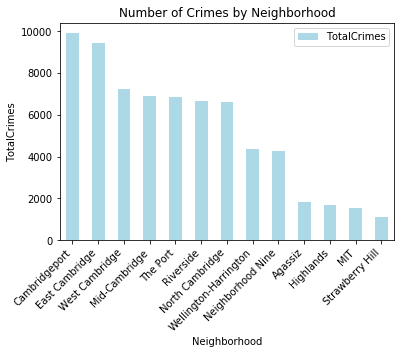

In [199]:

plotBarDF(dfCrimesGroupByNeighborhood,"Neighborhood","TotalCrimes",
                                            "Number of Crimes by Neighborhood",
                                            "Neighborhood",color="lightblue")



### Number of crimes by Type of crime

,Crime,CrimeCount
0,Hit and Run,6690
1,Larceny from MV,5717
2,Mal. Dest. Property,4665
3,Shoplifting,3929
4,Larceny of Bicycle,3875
5,Larceny from Building,3697
6,Warrant Arrest,3559
7,Forgery,3556
8,Housebreak,3159
9,Simple Assault,2873


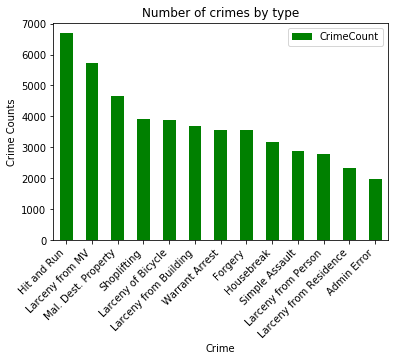

In [200]:
display(dfCrimesGroupByCrime)
plotBarDF(dfCrimesGroupByCrime,"Crime","Crime Counts",
                                            "Number of crimes by type",
                                            "Crime",color="green")

,Crime,CrimeCount
0,Hit and Run,6690
1,Larceny from MV,5717
2,Mal. Dest. Property,4665
3,Shoplifting,3929
4,Larceny of Bicycle,3875
5,Larceny from Building,3697
6,Warrant Arrest,3559
7,Forgery,3556
8,Housebreak,3159
9,Simple Assault,2873


[Text(0, 0, 'Hit and Run'),
 Text(0, 0, 'Larceny from MV'),
 Text(0, 0, 'Mal. Dest. Property'),
 Text(0, 0, 'Shoplifting'),
 Text(0, 0, 'Larceny of Bicycle'),
 Text(0, 0, 'Larceny from Building'),
 Text(0, 0, 'Warrant Arrest'),
 Text(0, 0, 'Forgery'),
 Text(0, 0, 'Housebreak'),
 Text(0, 0, 'Simple Assault'),
 Text(0, 0, 'Larceny from Person'),
 Text(0, 0, 'Larceny from Residence'),
 Text(0, 0, 'Admin Error')]

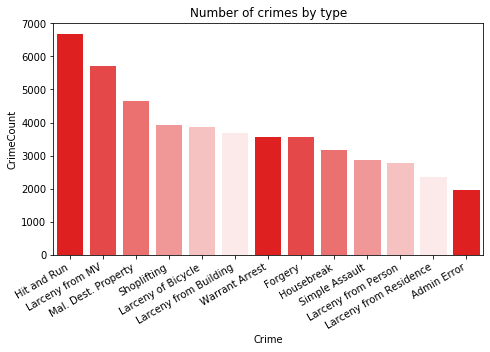

In [201]:
display(dfCrimesGroupByCrime)
fig, ax = plt.subplots()
fig.set_size_inches(7.7, 4.27)
sns.light_palette("green") 
ax = sns.barplot(x="Crime",y="CrimeCount",data=dfCrimesGroupByCrime,ax=ax,palette=sns.light_palette("red",reverse=True) )
ax.set(title="Number of crimes by type")

ax.set_xticklabels(labels=dfCrimesGroupByCrime["Crime"],rotation=30,ha="right")

,Neighborhood,TotalCrimes
0,Cambridgeport,9906
1,East Cambridge,9415
2,West Cambridge,7218
3,Mid-Cambridge,6882
4,The Port,6832
5,Riverside,6664
6,North Cambridge,6599
7,Wellington-Harrington,4345
8,Neighborhood Nine,4254
9,Agassiz,1836


[Text(0, 0, 'Cambridgeport'),
 Text(0, 0, 'East Cambridge'),
 Text(0, 0, 'West Cambridge'),
 Text(0, 0, 'Mid-Cambridge'),
 Text(0, 0, 'The Port'),
 Text(0, 0, 'Riverside'),
 Text(0, 0, 'North Cambridge'),
 Text(0, 0, 'Wellington-Harrington'),
 Text(0, 0, 'Neighborhood Nine'),
 Text(0, 0, 'Agassiz'),
 Text(0, 0, 'Highlands'),
 Text(0, 0, 'MIT'),
 Text(0, 0, 'Strawberry Hill')]

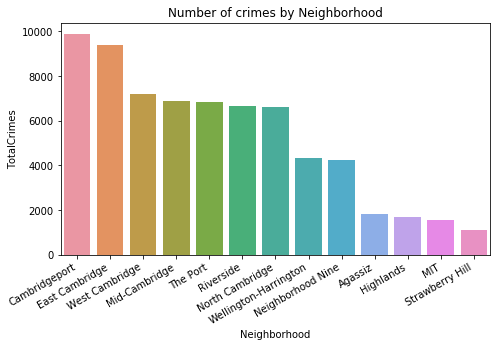

In [202]:
display(dfCrimesGroupByNeighborhood)
fig, ax = plt.subplots()
fig.set_size_inches(7.7, 4.27)
ax = sns.barplot(x="Neighborhood",y="TotalCrimes",data=dfCrimesGroupByNeighborhood,ax=ax)
ax.set(title="Number of crimes by Neighborhood")

ax.set_xticklabels(labels=dfCrimesGroupByNeighborhood["Neighborhood"],rotation=30,ha="right")

display(dfPopEmployeers.head())
plotBarDF(dfPopEmployeers,"employer","average",
                                            "Average Salary in company",
                                            "employer") #,color="green")

,#,Employer,# of employees
0,1,Harvard University,11997
1,2,Massachusetts Institute of Technology,8763
2,3,City of Cambridge,2950
3,4,Biogen,2700
4,5,Novartis,2457
5,6,Mount Auburn Hospital,2115
6,7,Cambridge Health Alliance,1713
7,8,Cambridge Innovation Center,1678
8,9,Genzyme,1600
9,10,Akamai Technologies,1544


[Text(0, 0, 'Harvard University'),
 Text(0, 0, 'Massachusetts Institute of Technology'),
 Text(0, 0, 'City of Cambridge'),
 Text(0, 0, 'Biogen'),
 Text(0, 0, 'Novartis'),
 Text(0, 0, 'Mount Auburn Hospital'),
 Text(0, 0, 'Cambridge Health Alliance'),
 Text(0, 0, 'Cambridge Innovation Center'),
 Text(0, 0, 'Genzyme'),
 Text(0, 0, 'Akamai Technologies')]

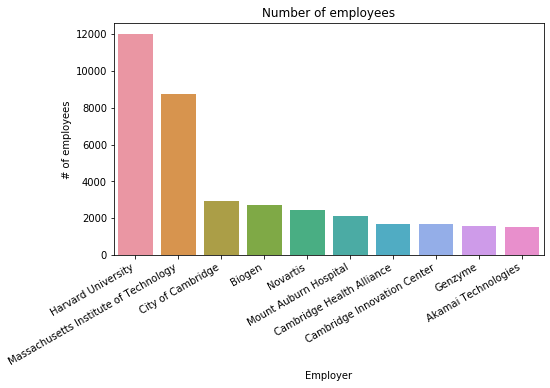

In [203]:
display(dfEmployeers)
fig, ax = plt.subplots()
fig.set_size_inches(7.7, 4.27)
ax = sns.barplot(x="Employer",y="# of employees",data=dfEmployeers,ax=ax)
ax.set(title="Number of employees")

ax.set_xticklabels(labels=dfEmployeers["Employer"],rotation=30,ha="right")

,Job,Average
6,Senior Software Engineer,126762
2,Senior Research Scientist-Biotechnology,114491
1,Research Scientist,99256
3,Research Scientist-Biotechnology,98537
0,Software Engineer,97070


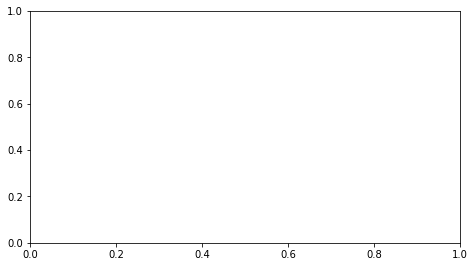

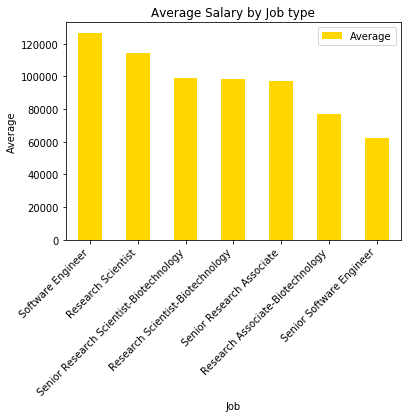

In [204]:
display(dfCamAvgSal.head())
fig, ax = plt.subplots()
fig.set_size_inches(7.7, 4.27)
plotBarDF(dfCamAvgSal,"Job","Average","Average Salary by Job type",
                                            "Job",color="gold")

[Text(0, 0, 'Senior Software Engineer'),
 Text(0, 0, 'Senior Research Scientist-Biotechnology'),
 Text(0, 0, 'Research Scientist'),
 Text(0, 0, 'Research Scientist-Biotechnology'),
 Text(0, 0, 'Software Engineer'),
 Text(0, 0, 'Senior Research Associate'),
 Text(0, 0, 'Research Associate-Biotechnology')]

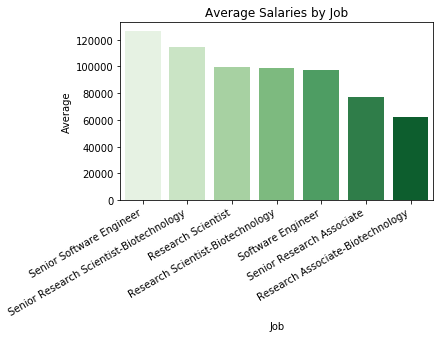

In [205]:
fig, ax = plt.subplots()
fig.set_size_inches(5.6, 3.27)
ax = sns.barplot( y=dfCamAvgSal["Average"], x=dfCamAvgSal["Job"],palette="Greens" ,ax=ax)
ax.set(title="Average Salaries by Job")
ax.set_xticklabels(labels=dfCamAvgSal["Job"],rotation=30,ha="right")

,Job,Average
6,Senior Software Engineer,126762
2,Senior Research Scientist-Biotechnology,114491
1,Research Scientist,99256
3,Research Scientist-Biotechnology,98537
0,Software Engineer,97070
4,Senior Research Associate,76817
5,Research Associate-Biotechnology,62042


[Text(0, 0, '126762'),
 Text(0, 0, '114491'),
 Text(0, 0, '99256'),
 Text(0, 0, '98537'),
 Text(0, 0, '97070'),
 Text(0, 0, '76817'),
 Text(0, 0, '62042')]

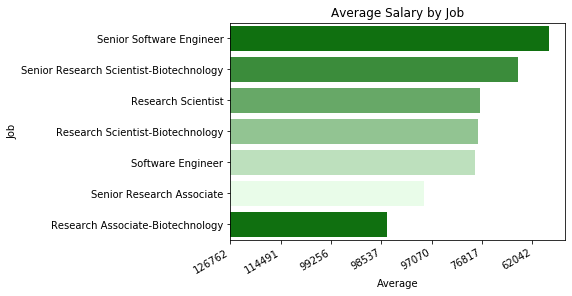

In [206]:
display(dfCamAvgSal)
ax = sns.barplot( y=dfCamAvgSal["Job"], x=dfCamAvgSal["Average"],palette=sns.light_palette("green",reverse=True)  )
ax.set(title="Average Salary by Job")
ax.set_xticklabels(labels=dfCamAvgSal["Average"],rotation=30,ha="right")

## 4- END Visualizations

# END Capstone Cambridge Project